# Homework #3
Josh Cohen

In [1]:
import sympy as sym
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
from IPython.display import Image
import pandas as pd

## Problem 6.5

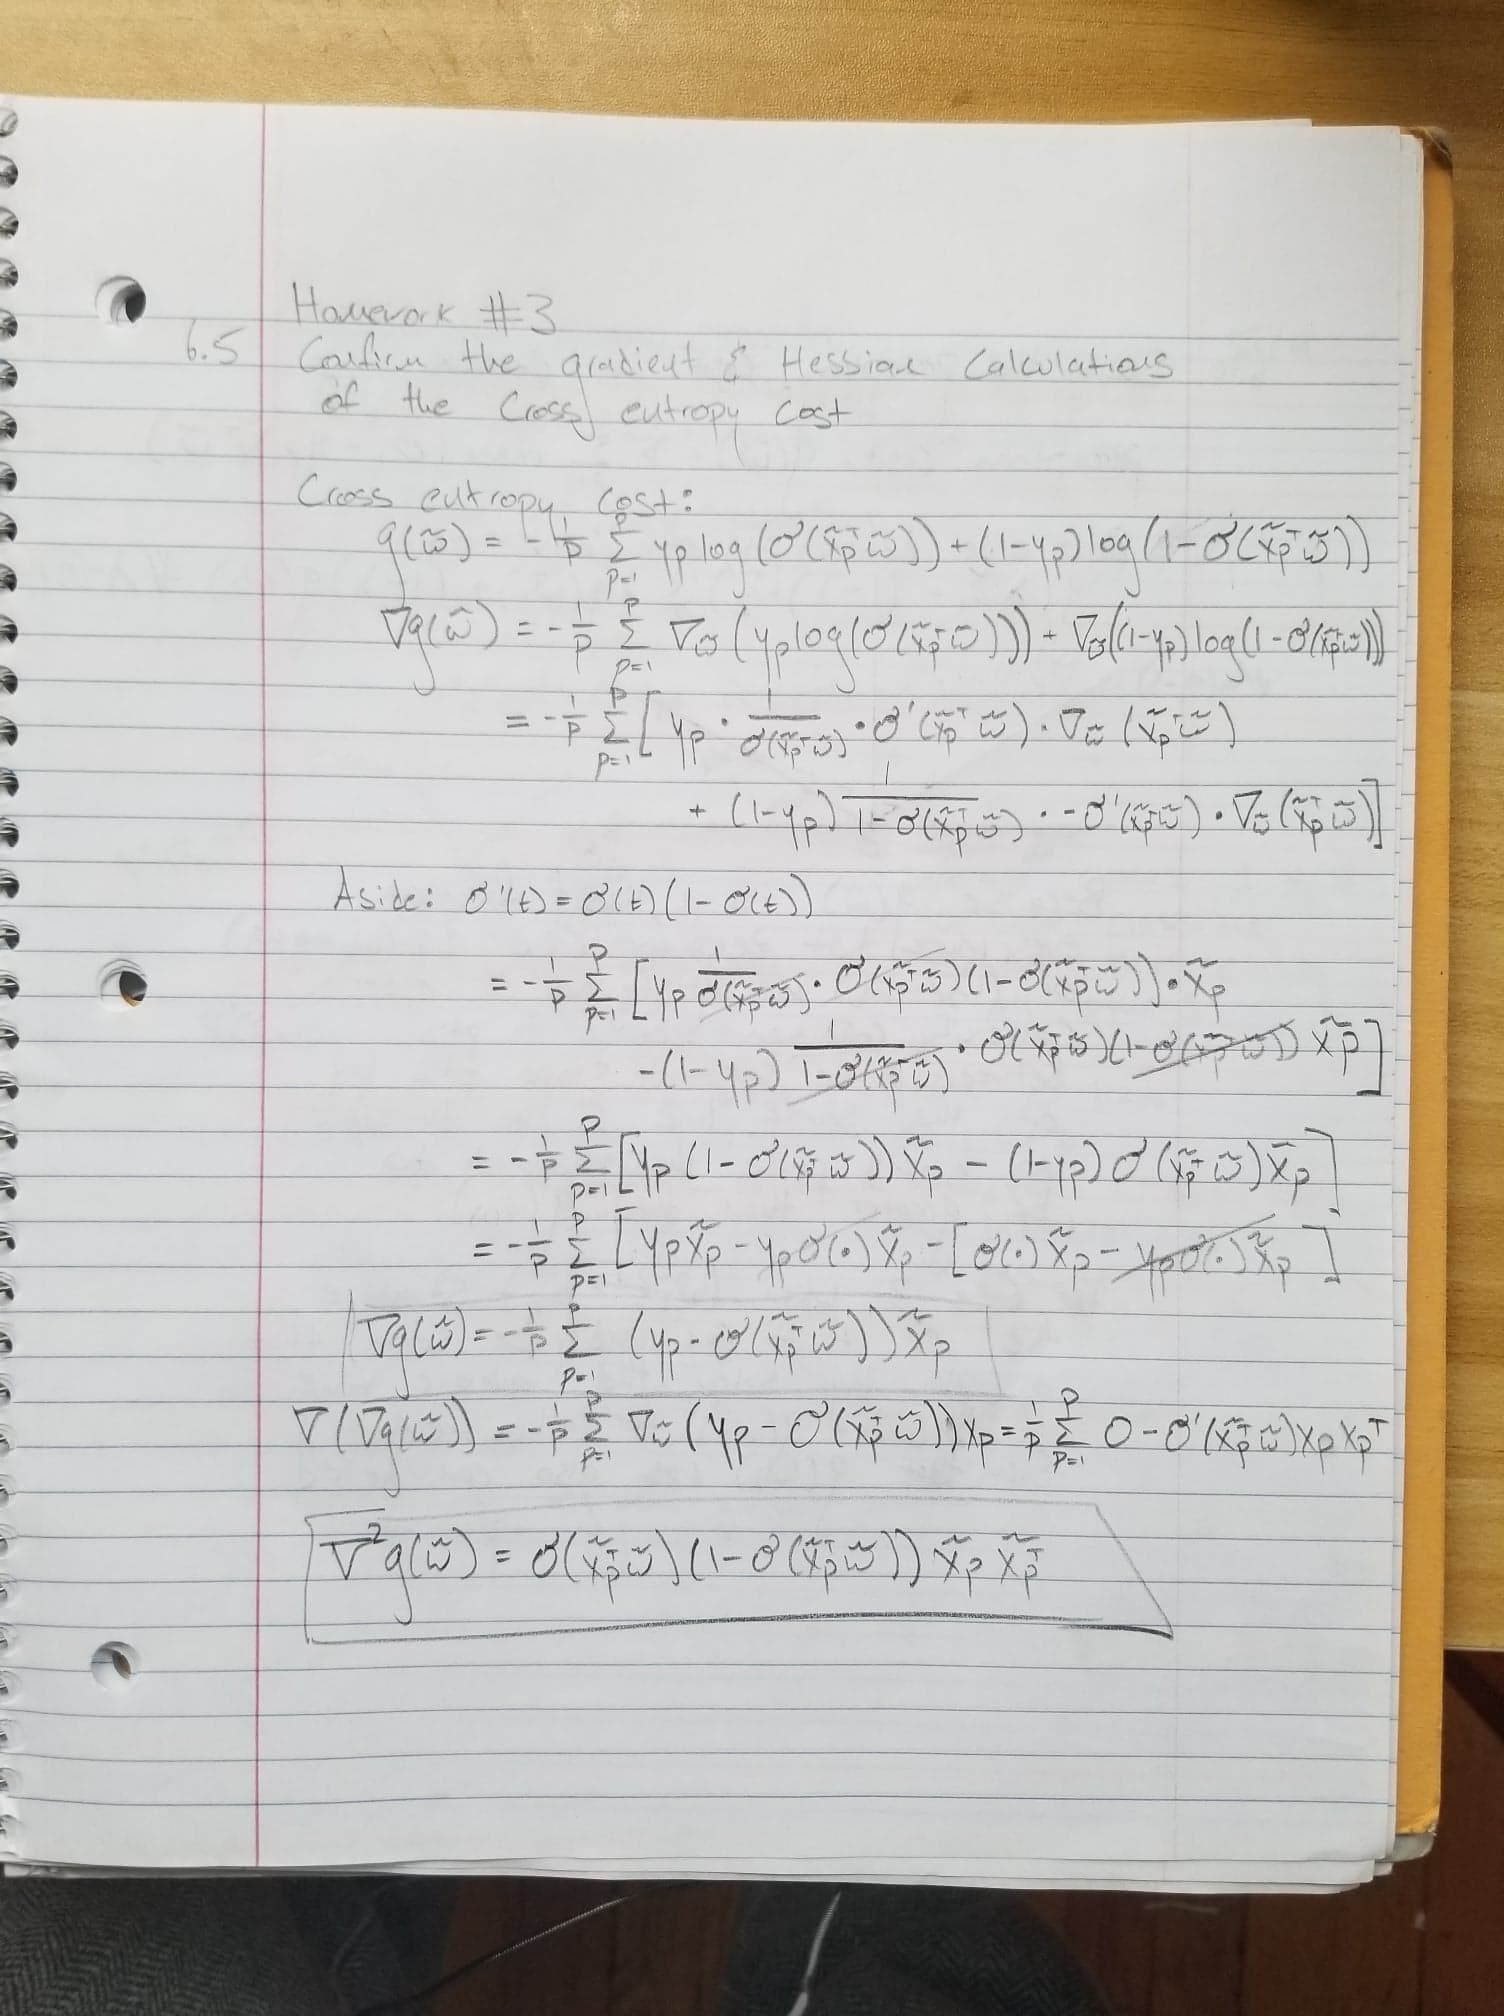

In [510]:
Image("65.jpg")

## Problem 6.10

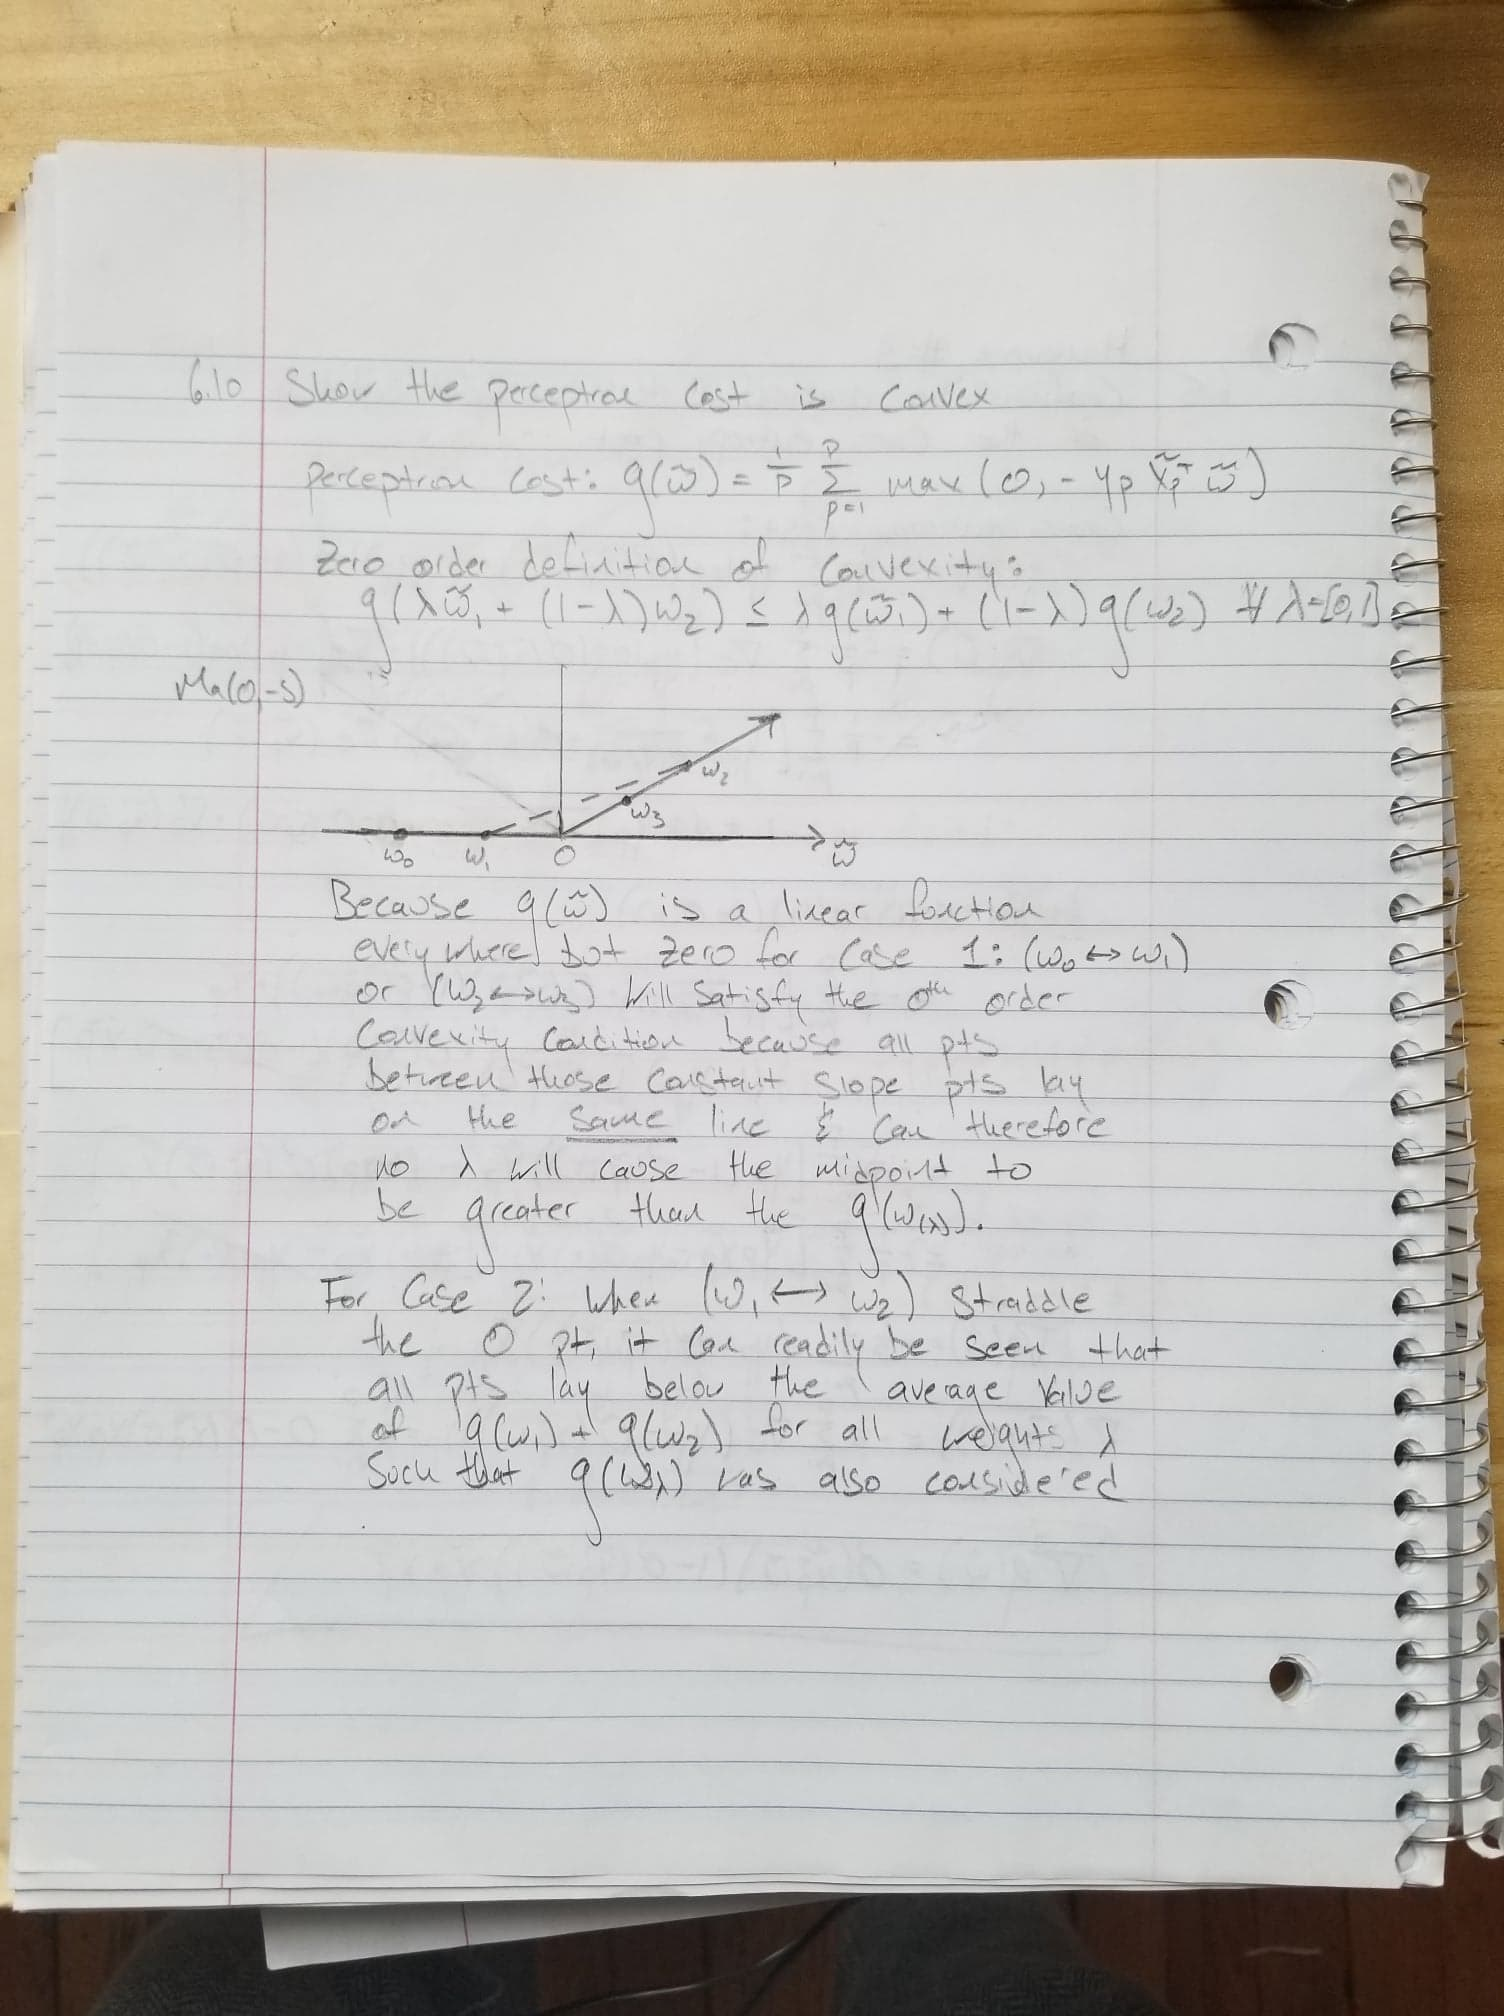

In [511]:
Image("610.jpg")

## Probelm 6.13

Compare efficacy of Softmax vs Perceptron cost functions in terms of minimum number of misclassifications by pursuing gradient descent based minimization

In [61]:
bc_df = pd.read_csv("breast_cancer_dataset.csv", header=None, index_col=None).dropna(axis=0)


In [118]:
yp = sym.symbols('y_p')
xp_tilde = sym.MatrixSymbol('\widetilde{x_p}', bc_df.shape[1], 1).as_explicit()
w_tilde = sym.MatrixSymbol('\widetilde{w}', bc_df.shape[1], 1).as_explicit()

In [119]:
#percep
cost = sym.Matrix([sym.log(1 + sym.exp(-yp * xp_tilde.T * w_tilde)[0])])
grad_cost = cost.jacobian(w_tilde)
cost_lam = sym.lambdify([yp, xp_tilde, w_tilde], cost)
grad_cost_lam = sym.lambdify([yp, xp_tilde, w_tilde],grad_cost)
# grad2_cost = grad_cost.jacobian(w_tilde)
# grad2_cost_lam = sym.lambdify([yp, xp_tilde, w_tilde], grad2_cost)

In [120]:
def p_cost(w_tilde):
    cost_sum = 0
    for i in range(bc_df.shape[0]):
        cost_sum += cost_lam(bc_df.iloc[i,-1], np.array([1,*bc_df.iloc[i, :-1].to_numpy()]), w_tilde)  * 1/bc_df.shape[0]
        
    ans = np.squeeze(cost_sum,axis=1)
    return ans

In [121]:
def grad_p_cost(w_tilde):
    grad_cost_sum = np.zeros(bc_df.shape[1])
    for i in range(bc_df.shape[0]):
#         thing = grad_cost_lam(bc_df.iloc[i,-1],np.array([1,*bc_df.iloc[i, :-1].to_numpy()]), w_tilde)
#         print(thing.shape)  
        grad_cost_sum += np.squeeze(grad_cost_lam(bc_df.iloc[i,-1],np.array([1,*bc_df.iloc[i, :-1].to_numpy()]), w_tilde), axis=0) * 1/bc_df.shape[0]
#         print(grad_cost_sum.shape)
    return grad_cost_sum 

In [127]:
def grad_2_p_cost(w_tilde):
    grad_2_cost_sum = np.zeros((bc_df.shape[1],bc_df.shape[1]))
    for i in range(bc_df.shape[0]):
#         print(grad_2_cost_sum)
        grad_2_cost_sum += grad2_cost_lam(bc_df.iloc[i,-1] , np.array([1,*bc_df.iloc[i, :-1].to_numpy()]) , w_tilde)
    
    return grad_2_cost_sum * 1/bc_df.shape[0]

In [130]:
def grad_desc(w_last):
    eps = 10e-3
    cost_vals = np.zeros(3000)
    num_its = 0
    cost_vals[0] = p_cost(w_last)
    grad_last = grad_p_cost(w_last)
#     grad_2_last = grad_2_p_cost(w_last)
    num_its += 1

    while(np.linalg.norm(grad_last) > eps):
#         w_next = w_last - np.matmul(np.linalg.inv(grad_2_last), grad_last)
        w_next = w_last - .1 *grad_last
        num_its += 1
        if (num_its > 1000):
            break;
        
        w_last = w_next
        cost_vals[num_its] = p_cost(w_last)
        grad_last = grad_p_cost(w_last)
#         grad_2_last = grad_2_p_cost(w_last)
        print(np.linalg.norm(grad_last))
    
    
    return w_last, cost_vals, num_its

In [ ]:
w_tilde = np.array([10, 1, 1, 1, 10, 1, 1, 1, 1, 1])
w, costs, its = grad_desc(w_tilde) 


In [ ]:
w_last = np.array([10, 1, 1, 1, 10, 1, 1, 1, 1, 1])
grad_last = grad_p_cost(w_last)
grad_2_last = grad_2_p_cost(w_last)
np.matmul(np.linalg.inv(grad_2_last), grad_last)

In [ ]:
w_last = np.array([10, 1, 1, 1, 1, 1, 1, 1, 1, 1])

grad_last = np.expand_dims(grad_p_cost(w_last),1)
grad_2_last = grad_2_p_cost(w_last)
print(grad_2_last)
np.matmul(grad_2_last.T, grad_last)

In [148]:
def misclass_calc_softmax(w_tilde):
    miscalc = 0
    for i in range(bc_df.shape[0]):
        xp_tilde = np.array([1,*bc_df.iloc[i, :-1].to_numpy()])
        yp = bc_df.iloc[i,-1]
        if np.sign(np.matmul(xp_tilde.T, w_tilde)) != np.sign(yp):
            miscalc +=1
    
    return miscalc

In [149]:
misclass_calc_softmax(w)

20

In [152]:
def missclass_calc_perceptron(w_tilde):
    miscalc = 0
    for i in range(bc_df.shape[0]):
        xp_tilde = np.array([1,*bc_df.iloc[i, :-1].to_numpy()])
        yp = bc_df.iloc[i,-1]
        if np.maximum(0, -yp * np.matmul(xp_tilde, w_tilde)) != 0:
            miscalc += 1
        
    return miscalc

In [153]:
missclass_calc_perceptron(w)

20

Both methods produced 20 misclassified elements

## Problem 6.15

In [301]:
cd_df = pd.read_csv("credit_dataset.csv", header=None, index_col=None).dropna(axis=0)

In [302]:
cd_mean = cd_df.iloc[:-1,:].mean(axis=1)
cd_std = cd_df.iloc[:-1,:].std(axis=1)
cd_std_norm = cd_df.iloc[:-1,:].sub(cd_mean, axis=0).div(cd_std, axis=0)

In [341]:
def setup_symbols(df, axis):
    N = df.shape[axis]
    print(N)
    yp = sym.symbols('y_p')
    xp_tilde = sym.MatrixSymbol('\widetilde{x_p}', N, 1).as_explicit()
    w_tilde = sym.MatrixSymbol('\widetilde{w}', N, 1).as_explicit()
    
    cost = sym.Matrix([sym.log(1 + sym.exp(-yp * xp_tilde.T * w_tilde)[0])])
    grad_cost = cost.jacobian(w_tilde)
    cost_lam = sym.lambdify([yp, xp_tilde, w_tilde], cost)
    grad_cost_lam = sym.lambdify([yp, xp_tilde, w_tilde],grad_cost)
#     grad2_cost = grad_cost.jacobian(w_tilde)
#     grad2_cost_lam = sym.lambdify([yp, xp_tilde, w_tilde], grad2_cost)
    
    return cost_lam, grad_cost_lam, grad2_cost_lam

In [308]:
#setup specific cost functions and link to df
cost_lam, grad_cost_lam, grad2_cost_lam = setup_symbols(cd_df, 0)
xp_tildes = cd_std_norm
yps = cd_df.iloc[-1,:].to_numpy()
df = cd_df
N = df.shape[0]
P = df.shape[1]

In [313]:
def cost(w_tilde):
    cost_sum = 0
#     print("AHHHHH")
    for i in range(P):
#         print(np.array([1,*xp_tildes.iloc[:,i].to_numpy()]).shape)
        cost_sum += cost_lam(yps[i], np.array([1,*xp_tildes.iloc[:,i].to_numpy()]), w_tilde)  * 1/P
        
    ans = np.squeeze(cost_sum,axis=1)
    return ans

In [314]:
def grad_cost(w_tilde):
    grad_cost_sum = np.zeros(N)
    for i in range(P):
        grad_cost_sum += np.squeeze(grad_cost_lam(yps[i], np.array([1,*xp_tildes.iloc[:,i].to_numpy()]), w_tilde), axis=0) * 1/P
    return grad_cost_sum 

In [315]:
# def grad_2_p_cost(w_tilde):
#     grad_2_cost_sum = np.zeros((cd_df.shape[0],cd_df.shape[0]))
#     for i in range(bc_df.shape[0]):
#         grad_2_cost_sum += grad2_cost_lam(bc_df.iloc[i,-1] , np.array([1,*bc_df.iloc[i, :-1].to_numpy()]) , w_tilde)
    
#     return grad_2_cost_sum * 1/df.shape[1]

In [318]:
def grad_desc(w_last):
    eps = 10e-3
    cost_vals = np.zeros(3000)
    num_its = 0
    cost_vals[0] = cost(w_last)
    grad_last = grad_cost(w_last)
    num_its += 1

    while(np.linalg.norm(grad_last) > eps):
        w_next = w_last - .1 *grad_last
        num_its += 1
        if (num_its > 1000):
            print("hit max its")
            break;
        
        w_last = w_next
        cost_vals[num_its] = cost(w_last)
        grad_last = grad_cost(w_last)
        print(np.linalg.norm(grad_last))
    
    
    return w_last, cost_vals, num_its

In [ ]:
w_tilde = np.ones(21)
w, costs, its = grad_desc(w_tilde)

In [320]:
def confusion_matrix_gen(w_tilde):
    confusion_matrix = pd.DataFrame(np.zeros((2,2)), index=["a_bad", "a_good"], columns=["p_bad", "p_good"]).astype('int')
    for i in range(df.shape[1]):
        xp_tilde = np.array([1,*xp_tildes.iloc[:,i].to_numpy()])
        yp = yps[i]
        #correctly predicted
        if np.sign(np.matmul(xp_tilde.T, w_tilde)) == np.sign(yp):
            #pg, ag
            if (yp > 0):
                confusion_matrix.loc["a_good", "p_good"] += 1
            else:
                confusion_matrix.loc["a_bad", "p_bad"] += 1
                
        else:
            if (yp > 0):
                confusion_matrix.loc["a_good", "p_bad"] += 1
            else:
                confusion_matrix.loc["a_bad", "p_good"] += 1
                
    return confusion_matrix

In [321]:
confusion_matrix = confusion_matrix_gen(w)

In [322]:
confusion_matrix

,p_bad,p_good
a_bad,146,154
a_good,76,624


In [323]:
acurracy = 1 - (confusion_matrix.loc["a_good", "p_bad"] + confusion_matrix.loc["a_bad", "p_good"])/1000

In [324]:
acurracy

0.77

Therefore it can be seen that we achieved 77% accuracy

## Probelm 6.16

In [458]:
mbal_df = pd.read_csv("3d_classification_data_v2_mbalanced.csv", header=None, index_col=None)
mbal_df.shape

(3, 55)

In [463]:
#Non weighted calssification
#setup specific cost functions and link to df
# cost_lam, grad_cost_lam, grad2_cost_lam = setup_symbols(mbal_df, 0)
yp, betap = sym.symbols('y_p beta_p')
xp_tilde = sym.MatrixSymbol('\widetilde{x_p}', N, 1).as_explicit()
w_tilde = sym.MatrixSymbol('\widetilde{w}', N, 1).as_explicit()

cost = sym.Matrix([betap * sym.log(1 + sym.exp(-yp * xp_tilde.T * w_tilde)[0])])
grad_cost = cost.jacobian(w_tilde)
grad2_cost = grad_cost.jacobian(w_tilde)

cost_lam = sym.lambdify([yp, betap, xp_tilde, w_tilde], cost)
grad_cost_lam = sym.lambdify([yp, betap, xp_tilde, w_tilde],grad_cost)
grad2_cost_lam = sym.lambdify([yp, betap, xp_tilde, w_tilde], grad2_cost)

df = mbal_df
N = df.shape[0] 
P = df.shape[1]

In [464]:
cost

Matrix([[beta_p*log(exp(-y_p*\widetilde{w}[0, 0]*\widetilde{x_p}[0, 0] - y_p*\widetilde{w}[1, 0]*\widetilde{x_p}[1, 0] - y_p*\widetilde{w}[2, 0]*\widetilde{x_p}[2, 0]) + 1)]])

In [465]:
yps = df.iloc[-1,:]
xp_tildes = df.iloc[:-1,:]

In [466]:
def cost(w_tilde, weight):
    cost_sum = 0
    for i in range(P):
        yp = yps[i]
        if (yp == 1):
            bp = 1
        elif (yp == -1):
            bp = weight
        cost_sum += cost_lam(yp, bp, np.array([1,*xp_tildes.iloc[:,i].to_numpy()]), w_tilde)  * 1/P
        
    ans = np.squeeze(cost_sum,axis=1)
    return ans

In [467]:
def grad_cost(w_tilde, weight):
    grad_cost_sum = np.zeros(N)
    for i in range(P):
        yp = yps[i]
        if (yp == 1):
            bp = 1
        elif (yp == -1):
            bp = weight
        grad_cost_sum += np.squeeze(grad_cost_lam(yp, bp, np.array([1,*xp_tildes.iloc[:,i].to_numpy()]), w_tilde), axis=0) * 1/P
    
    return grad_cost_sum 

In [468]:
def grad2_cost(w_tilde, weight):
    grad2_cost_sum = np.zeros((N,N))
    for i in range(P):
        yp = yps[i]
        if (yp == 1):
            bp = 1
        elif (yp == -1):
            bp = weight
        grad2_cost_sum += grad2_cost_lam(yp, bp, np.array([1,*xp_tildes.iloc[:,i].to_numpy()]) , w_tilde) * 1/P
    
    return grad2_cost_sum 

In [469]:
def grad_desc(w_last, weight):
    eps = 10e-3
    cost_vals = np.zeros(3000)
    num_its = 0
    cost_vals[0] = cost(w_last, weight)
    grad_last = grad_cost(w_last, weight)
    grad2_last = grad2_cost(w_last, weight)
    num_its += 1
    steps = 5
    eps = .001
    for i in range(steps):
        w_next = w_last - np.matmul(np.linalg.inv(grad2_last + eps * np.eye(N)),grad_last)
        num_its += 1
        if (num_its > 1000):
            print("hit max its")
            break;
        
        w_last = w_next
        cost_vals[num_its] = cost(w_last, weight)
        grad_last = grad_cost(w_last, weight)
        grad2_last = grad2_cost(w_last, weight)
        print(np.linalg.norm(grad_last))
    
    
    return w_last, cost_vals, num_its

In [494]:
w, costs, its = grad_desc(np.array([3, -1, -1]), 1)

0.09206934439191436
0.21174023643425482
0.027435087017300245
0.007084143461316065
0.002726270473563379


In [495]:
def missclass_calc(w_tilde):
    miscalc = 0
    for i in range(P):
        xp_tilde = np.array([1,*xp_tildes.iloc[:,i].to_numpy()])
        yp = yps[i]
        if np.maximum(0, -yp * np.matmul(xp_tilde, w_tilde)) != 0:
            miscalc += 1
        
    return miscalc

In [496]:
num_miss = missclass_calc(w)

In [497]:
a_0 = "a_R"
a_1 = "a_B"
p_0 = "p_R"
p_1 = "p_B"
def confusion_matrix_gen(w_tilde):
    
    confusion_matrix = pd.DataFrame(np.zeros((2,2)), index=[a_0, a_1], columns=[p_0,p_1]).astype('int')
    for i in range(P):
        xp_tilde = np.array([1,*xp_tildes.iloc[:,i].to_numpy()])
        yp = yps[i]
        #correctly predicted
        if np.sign(np.matmul(xp_tilde.T, w_tilde)) == np.sign(yp):
            #pg, ag
            if (yp > 0):
                confusion_matrix.loc[a_0, p_0] += 1
            else:
                confusion_matrix.loc[a_1, p_1] += 1
                
        else:
            if (yp > 0):
                confusion_matrix.loc[a_0, p_1] += 1
            else:
                confusion_matrix.loc[a_1, p_0] += 1
                
    return confusion_matrix

In [498]:
confusion_matrix_unweight = confusion_matrix_gen(w)

In [499]:
confusion_matrix_unweight

,p_R,p_B
a_R,3,2
a_B,0,50


In [500]:
#unbalanced accuracy
unbal_acc = 1 - 1/ P *num_miss 
#balanced accuracy
red_acc = 1 - 1/(confusion_matrix_unweight.loc["a_R"].sum()) * confusion_matrix_unweight.loc["a_R", "p_B"]
blue_acc = 1 - 1/(confusion_matrix_unweight.loc["a_B"].sum()) * confusion_matrix_unweight.loc["a_B", "p_R"]
balanced_acc = (red_acc + blue_acc) /2
print("WEIGHT B = 1")
print("unbalanced classification accuracy: {:0.4f}".format(unbal_acc))
print("red class accuracy: {:.4f}".format(red_acc))
print("blue class accuracy: {:.4f}".format(blue_acc))
print("resulting balanced class accuracy: {:.4f}".format(balanced_acc))

WEIGHT B = 1
unbalanced classification accuracy: 0.9636
red class accuracy: 0.6000
blue class accuracy: 1.0000
resulting balanced class accuracy: 0.8000


In [501]:
w, costs, its = grad_desc(np.array([3, -1, -1]), 1/5)

0.07390558410810351
0.024902714491193502
0.004050780550253439
0.001838294500389559
0.001423678064106507


In [502]:
num_miss = missclass_calc(w)
num_miss

4

In [503]:
confusion_matrix_w5 = confusion_matrix_gen(w)
confusion_matrix_w5

,p_R,p_B
a_R,4,1
a_B,3,47


In [504]:
#beta = 5
unbal_acc = 1 - 1/ P *num_miss 
#balanced accuracy
red_acc = 1 - 1/(confusion_matrix_w5.loc["a_R"].sum()) * confusion_matrix_w5.loc["a_R", "p_B"]
blue_acc = 1 - 1/(confusion_matrix_w5.loc["a_B"].sum()) * confusion_matrix_w5.loc["a_B", "p_R"]
balanced_acc = (red_acc + blue_acc) /2
print("WEIGHT B = 5")
print("unbalanced classification accuracy: {:0.4f}".format(unbal_acc))
print("red class accuracy: {:.4f}".format(red_acc))
print("blue class accuracy: {:.4f}".format(blue_acc))
print("resulting balanced class accuracy: {:.4f}".format(balanced_acc))

WEIGHT B = 5
unbalanced classification accuracy: 0.9273
red class accuracy: 0.8000
blue class accuracy: 0.9400
resulting balanced class accuracy: 0.8700


In [505]:
w, costs, its = grad_desc(np.array([3, -1, -1]), 1/10)

0.053564114343693826
0.0038527327260003607
0.0021050375129540054
0.001608489211417099
0.001317451137449592


In [506]:
num_miss = missclass_calc(w)
num_miss

5

In [507]:
confusion_matrix_w10 = confusion_matrix_gen(w)
confusion_matrix_w10

,p_R,p_B
a_R,5,0
a_B,5,45


In [512]:
#beta = 10
unbal_acc = 1 - 1/ P *num_miss 
#balanced accuracy
red_acc = 1 - 1/(confusion_matrix_w10.loc["a_R"].sum()) * confusion_matrix_w10.loc["a_R", "p_B"]
blue_acc = 1 - 1/(confusion_matrix_w10.loc["a_B"].sum()) * confusion_matrix_w10.loc["a_B", "p_R"]
balanced_acc = (red_acc + blue_acc) /2
print("WEIGHT B = 10")
print("unbalanced classification accuracy: {:0.4f}".format(unbal_acc))
print("red class accuracy: {:.4f}".format(red_acc))
print("blue class accuracy: {:.4f}".format(blue_acc))
print("resulting balanced class accuracy: {:.4f}".format(balanced_acc))

WEIGHT B = 10
unbalanced classification accuracy: 0.9091
red class accuracy: 1.0000
blue class accuracy: 0.9000
resulting balanced class accuracy: 0.9500
